In [369]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh, VOL, BND
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot, exp

In [21]:
R = 10.
H = 1.

def CreateMesh( h_max = 2.):
    '''Creates a netgen mesh and returns the NG-solve wrapper.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_p","Gamma","Sigma_n"],
                    leftdomain=1,
                    rightdomain=0)
    geo.AddCircle(c=(0,0),
                r=0.4,
                bc="dOmega",
                leftdomain=2,
                rightdomain=1)
    geo.SetMaterial (1, "Omega_e")
    geo.SetMaterial (2, "Omega_i")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega

Omega = CreateMesh()

In [4]:
Interior = Omega.Materials('Omega_e | Omega_i')

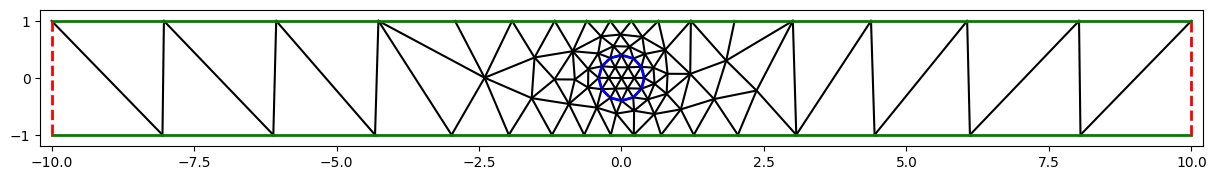

In [22]:
def plot_mesh( M : Mesh, ax : plt.Axes | None = None): 
    """Plots a mesh"""
    points = np.fromiter( (v.point for v in M.vertices), dtype=np.dtype((float, 2)), count=M.nv)
    
    if ax is None:
        _, ax = plt.subplots( figsize=(15,3))
    for l in M.edges:
        if len(l.elements) == 2:
            px, py = points[l.vertices[0].nr]
            qx, qy = points[l.vertices[1].nr]
            ax.plot( [px, qx], [py, qy], 'k')

    lw = 2

    for e in M.Boundaries("Gamma").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], 'g', linewidth=lw)

    for e in M.Boundaries("Sigma_p").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)

    for e in M.Boundaries("Sigma_n").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)


    for e in M.Boundaries("dOmega").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--b', linewidth=lw)


    #ax.scatter(x=points[:,0], y=points[:,1])
    d = 0.2
    ax.axis('square')
    ax.set_xlim([-R-d,R+d])
    ax.set_ylim([-H-d,H+d])


plot_mesh(Omega)


Lets check for counter clockwise-ness

In [23]:
# def cross_product(ux, uy, vx, vy):
#     cp = ux*vy - uy*vx
#     return cp

# vertices = list(Omega.vertices)

# triangles = list(Omega.faces)

# def is_counterclockwise(K):
#     px, py = vertices[K.vertices[0].nr].point
#     qx, qy = vertices[K.vertices[1].nr].point
#     rx, ry = vertices[K.vertices[2].nr].point
#     ux = qx - px
#     uy = qy - py 
#     vx = rx - px 
#     vy = ry - py
#     cp = cross_product(ux,uy,vx,vy)
#     return cp > 0

# for K in triangles:
#     print(is_counterclockwise(K))

    

I think its easier if we force it to be counter-clockwise

In [7]:
# cc_triangles = []
# for K in triangles:
#     if is_counterclockwise(K):
#         cc_triangles.append(K.vertices)
#     else:
#         cc_triangles.append((K.vertices[1],K.vertices[0],K.vertices[2]))

In [8]:
# def is_counterclockwise(K):
#     px, py = vertices[K[0].nr].point
#     qx, qy = vertices[K[1].nr].point
#     rx, ry = vertices[K[2].nr].point
#     ux = qx - px
#     uy = qy - py 
#     vx = rx - px 
#     vy = ry - py
#     cp = cross_product(ux,uy,vx,vy)
#     return cp > 0


# for K in cc_triangles:
#     print(is_counterclockwise(K))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


The vertices in each triangle are not given in a clockwise or counter-clockwise manner in general. For that reason the normal vector is hardcoded.

In [372]:
from enum import Enum, auto

class EdgeType(Enum):
    INNER = auto()
    GAMMA = auto()
    SIGMA_L = auto()
    SIGMA_R = auto()



class Edge:
    '''Holds all the information from an edge that is needed:
    - P : inital vertex
    - Q : end point
    - N : normal
    - T : tangent
    - Type: EdgeType: {Inner, Gamma, Sigma_L, Sigma_R}
    - Triangless: tuple of one or two element IDs.'''

    def __init__(self, Omega, edge ):
        P = np.array( Omega.vertices[edge.vertices[0].nr].point)
        Q = np.array( Omega.vertices[edge.vertices[1].nr].point)        
        self.P = P
        self.Q = Q
        self.Type = self.getEdgeType()
        self.N = self.getNormal()
        self.T = self.getTangent() 
        self.Triangles = [ K.nr for K in edge.elements ]

#        probably they should be properties with getters and setters, fix later    

    def getEdgeType(self):
        px, py = self.P 
        qx, qy = self.Q 

        if py == qy == H:
            return EdgeType.GAMMA
        if py == qy == -H:
            return EdgeType.GAMMA
        if px == qx == R:
            return EdgeType.SIGMA_R
        if py == qy == -R:
            return EdgeType.SIGMA_L
        else:
            return EdgeType.INNER


    def getNormal(self):
        px, py = self.P 
        qx, qy = self.Q 
        tx, ty = self.Q - self.P

        match self.Type:
            
            case EdgeType.GAMMA:
                return np.array([0., py / np.abs(py)])
            
            case EdgeType.SIGMA_L:
                return np.array([-1., 0.])

            case EdgeType.SIGMA_R:
                return np.array([1., 0.])

            case EdgeType.INNER:
                return np.array([ -ty, tx] ) / norm([tx,ty])


    def getTangent(self):
        T = (self.Q - self.P) / norm(self.Q - self.P)
        return T


    


Vertices = np.array([ list(v.point) for v in Omega.vertices])
Edges = [ Edge(Omega, e)  for e in Omega.edges ]


Checking the orientation of the normals...

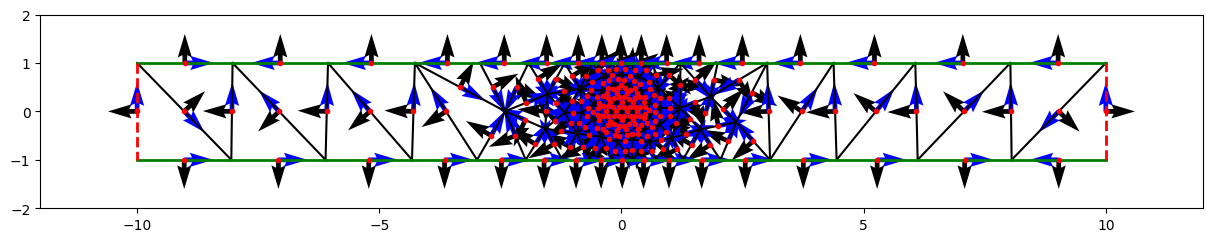

In [374]:
def CheckNormals(Omega, Vertices, Edges):
    MidPoints = np.array([ (E.P + E.Q)/2 for E in Edges] )
    Normals = np.array( [ E.N for E in Edges])
    Tangents = np.array( [ E.T for E in Edges])
    plot_mesh(Omega)
    plt.plot( MidPoints[:,0], MidPoints[:,1],'.r')
    plt.quiver( MidPoints[:,0], MidPoints[:,1], Normals[:,0], Normals[:,1], scale=40)
    plt.quiver( MidPoints[:,0], MidPoints[:,1], Tangents[:,0], Tangents[:,1], scale=40, color='b')
    plt.xlim([-12,12])
    plt.ylim([-2,2])

CheckNormals(Omega, Vertices, Edges)

In [272]:
class TrefftzSpace:
    '''Defines a finite dimensional Trefftz space given
    a mesh, the number of plane-waves per element and 
    the wave-numbers.

    It can create test and trial functions, aswell as 
    actual functions.
    '''

    def __init__( self, Omega, DOF_per_element : tuple[int], kappa : dict[str, float] ):
        self.Omega = Omega
        self.N_elements = Omega.ne
        self.kappa = np.array( [ kappa[e.mat] for e in Omega.Elements()])
        th0 = 0.
        if hasattr(DOF_per_element, '__iter__'):
            assert Omega.ne == len(DOF_per_element)
            self.local_N_DOF = np.array( DOF_per_element )
        else:
            self.local_N_DOF = np.full_like(self.kappa, fill_value=DOF_per_element,dtype=np.int32)
        self.N_DOF = np.sum(self.local_N_DOF)
        # self.d =  [ list(map( lambda th: [ np.cos(th), np.sin(th)] , 
        #                               th0 + np.linspace(0, 2*np.pi, N, endpoint=False)))  for N in self.local_N_DOF] 

        self.d = [ np.array([[np.cos(th0 +th), np.sin(th0+th)] for th in np.linspace(0,2*np.pi,N,endpoint=False)]) 
                  for N in self.local_N_DOF ] 


        self.DOF_ownership = np.repeat( range(self.N_elements), self.local_N_DOF)
        self.DOF_start = np.cumsum(self.local_N_DOF) - self.local_N_DOF
        self.DOF_end = np.cumsum(self.local_N_DOF)
        self.DOF_range = [ list(range(s,e)) for (s,e) in zip(self.DOF_start,self.DOF_end)]
        self.global_to_local = np.array( [ n for N in self.local_N_DOF for n in range(N)])

    @property
    def TestFunctions( self ):
        return [ TestFunction( k= self.kappa[self.DOF_ownership[n]], d=self.d[self.DOF_ownership[n]][self.global_to_local[n]]) for n in range(self.N_DOF)]
    @property
    def TrialFunctions( self ):
        return [ TestFunction( k= self.kappa[self.DOF_ownership[n]], d=self.d[self.DOF_ownership[n]][self.global_to_local[n]]) for n in range(self.N_DOF)]



class TrefftzFunction:
    def __init__( self, V, coeffs = 0.):
        '''Returns a Trefftz function with coefficients "coeffs"'''
        self.V = V
        self.coeffs = coeffs


    def Element(self, x, y ):
        return self.V.Omega(x,y).nr
    
    @property
    def coeffs( self ):
        return self._coeffs

    
    @coeffs.setter
    def coeffs( self, values):
        if hasattr(values, '__iter__'):
            assert self.V.N_DOF == len(values)
            self._coeffs = np.array(values)
        else:
            self._coeffs = np.full( self.V.N_DOF, values, dtype=np.complex128)


    def __call__(self, x, y ):
        e = self.Element(x,y)
        k = self.V.kappa[e]
        P = self.coeffs[self.V.DOF_range[e]]
        D = self.V.d[e]

        r = np.array([x,y])
        y = sum( p*np.exp(1j*k*dot(d,r)) for (p,d) in zip(P,D) )
        return y 

from collections import namedtuple

TestFunction = namedtuple("TestFunction", ["k", "d"])

    

In [273]:
# V = TrefftzSpace(Omega, np.tile([2,3], Omega.ne//2),{"Omega_i" : 1. , "Omega_e" : 2.})


Nth = 10
V = TrefftzSpace(Omega, Nth, {"Omega_i" : 15. , "Omega_e" : 7.})

Psi = V.TestFunctions
Psi[4].d

array([-0.80901699,  0.58778525])

In [274]:
# class TrefftzFun:
#     def __init__( self, Omega : Mesh, Np : list[int], kappa : list[float]):
#         assert Omega.ne == len(Np)
#         self.Ncoef = sum(Np) 
#         self.Np = Np
#         self.coefs = np.zeros(self.Ncoef, dtype=np.complex128)
#         self.kappa = kappa
       
#         self.e_to_coef = np.zeros( (Omega.ne,2), dtype=np.int32)
#         i = 0
#         for e in range(Omega.ne):
#             self.e_to_coef[e,:] = np.array( i, Np[e])
#             i += Np[e]
    

#     def set_coeffs( self, coeffs):
#         self.coefs = coeffs


#     def __call__(self, x, y ):
#         e_ID = Omega(x,y).nr
#         k = self.kappa[e_ID]
#         id0 = self.e_to_coef[e_ID,0]
#         y = sum( [self.coefs[id0+n] * np.exp(1j*k*(x*np.cos(th) + y*np.sin(th))) 
#                   for (n,th) in enumerate(np.linspace(0,2*np.pi, self.Np[e_ID], endpoint=False))] )
#         return y 



In [275]:
# Nth = 3
# Np = np.full(Omega.ne, Nth, dtype=np.int32) #homogeneous number of plane waves
# k_in = 70
# k_out = 7
# kappa = [ k_out if e.mat == "Omega_e" else k_in for e in Omega.Elements()]
# f = TrefftzFun(Omega, Np, kappa)

In [276]:
#coeffs = np.random.randint(20,size=Nth*Omega.ne)
coeffs = 10*np.random.uniform(-1, 1, Nth*Omega.ne) + 10*1.j * np.random.uniform(-1, 1, Nth*Omega.ne)
f = TrefftzFunction(V,coeffs)

In [277]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])



(-1.0, 1.0)

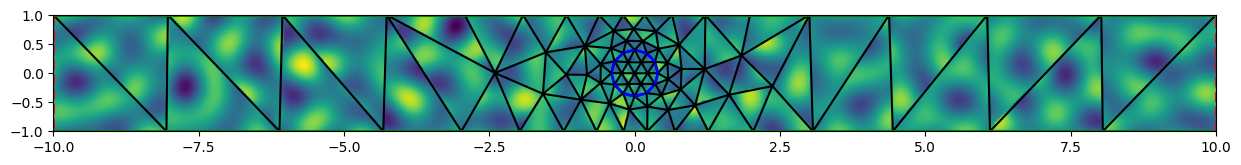

In [278]:
_, ax = plt.subplots( figsize=(15,3))
ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
plot_mesh(Omega, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])


(-1.0, 1.0)

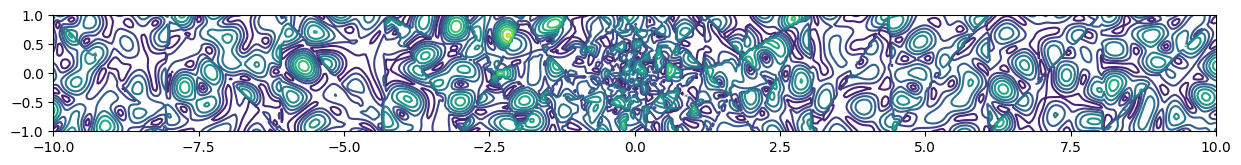

In [279]:
_, ax = plt.subplots( figsize=(15,3))
ax.contour(X,Y,np.abs(Z),10)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])


# Naive Implementation:

This implementation should not be stable

In [280]:
N_DOF = V.N_DOF


A = np.zeros((N_DOF,N_DOF), dtype=np.complex128)
b = np.zeros((N_DOF), dtype=np.complex128)

In [297]:
Phi = V.TrialFunctions
Psi = V.TestFunctions # currently the same spaces 
for e_ID, K in enumerate(V.Omega.Elements(VOL)):
    for  n in V.DOF_range[e_ID]:
        phi = Phi[n]
        for s_ID, E in enumerate(K.edges):
            match E.type:
                case EdgeType.INNER:
                    for m in V.DOF_range[e_ID]:
                        psi = Psi[m]
                        A[m,n] += same_elem_term(phi, psi, E)

                    for m in V.DOF_range[ Neighbours[e_ID, s_ID] ]: 
                        psi = Psi[m]
                        A[m,n] += neighbour_elem_term(phi, psi, E)


                case EdgeType.GAMMA:
                    for m in V.DOF_range[e]:
                        psi = Psi[m]
                        A[m,n] += Gamma_term(phi, psi, E)
                         
                case EdgeType.SIGMA_L:
                    pass
                case EdgeType.SIGMA_R:
                    pass



In [295]:
from numpy import dot, exp

def Gamma_term(phi, psi, edge):
    kd_n = phi["k"] * phi["d"]
    kd_m = psi["k"] * psi["d"]
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T

    I = dot(kd_m, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )
    return I 

def same_elem_term(phi, psi, edge):
    kd_n = phi["k"] * phi["d"]
    kd_m = psi["k"] * psi["d"]
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T

    I = 0.5 * dot(kd_m + kd_n, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )
    return I 

def neighbour_elem_term(phi, psi, edge):
    kd_n = phi["k"] * phi["d"]
    kd_m = psi["k"] * psi["d"]
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T

    I = -0.5 * dot(kd_m + kd_n, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )
    return I 


In [330]:
E = [ e for e in Omega.faces]

In [335]:
E[0].edges

(E0, E6, E1)

(E19, E127, E23)

In [313]:
S = [s for s in Omega.edges ]

In [342]:
for e in S[1].elements:
    print(e.nr)

0


In [ ]:
Phi = V.TrialFunctions
Psi = V.TestFunctions # currently the same spaces 
for E in Edges:
    match E.type:
        case EdgeType.INNER:
            for m in V.DOF_range[e_ID]:
                psi = Psi[m]
                A[m,n] += same_elem_term(phi, psi, E)

            for m in V.DOF_range[ Neighbours[e_ID, s_ID] ]: 
                psi = Psi[m]
                A[m,n] += neighbour_elem_term(phi, psi, E)


        case EdgeType.GAMMA:
            for m in V.DOF_range[e]:
                psi = Psi[m]
                A[m,n] += Gamma_term(phi, psi, E)
                
        case EdgeType.SIGMA_L:
            pass
        case EdgeType.SIGMA_R:
            pass